# Introduction

This notebook presents **YOLOv2** applied to the [Blood Cell Images](https://www.kaggle.com/paultimothymooney/blood-cells) dataset.

**Resources**

* [BCCD Dataset](https://github.com/Shenggan/BCCD_Dataset) - alternative dataset source with links to original authors

# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import PIL
import PIL.Image
import PIL.ImageDraw
import xml.etree.ElementTree as ET


Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

# Configuration

In [3]:
dataset_location = '/home/marcin/Datasets/blood-cells/dataset-master/'

In [4]:
anchors = ((0.57273, 0.677385),  # anchor-box nb 1, width & height, unit: cell_size
           (1.87446, 2.06253),   # anchor-box nb 2,
           (3.33843, 5.47434),   # ...
           (7.88282, 3.52778),
           (9.77052, 9.16828))

In [5]:
classes = ['RBC']

In [6]:
images_location = os.path.join(dataset_location, 'JPEGImages')
annotations_location = os.path.join(dataset_location, 'Annotations')

In [7]:
filename_list_xml = sorted(os.listdir(annotations_location))
display(filename_list_xml[:3])

['BloodImage_00000.xml', 'BloodImage_00001.xml', 'BloodImage_00002.xml']

In [8]:
class ImageWrapper:
    def __init__(self, filepath, width, height, depth):
        self.filepath = filepath
        self.width = width
        self.height = height
        self.depth = depth
        self.objects = []
    def __str__(self):
        return f'{self.filepath}\nw:{self.width} h:{self.height} d:{self.depth}'

In [9]:
class BBoxWrapper:
    def __init__(self, name, xmin ,ymin, xmax, ymax):
        self.name = name
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
    def __str__(self):
        return f'{self.name} {self.xmin} {self.ymin} {self.xmax} {self.ymax}'

In [10]:
image_wrapper_list = []

for filename_xml in filename_list_xml:       # 'BloodImage_00000.xml'
    filepath_xml = os.path.join(             # '/../../BloodImage_00000.xml'
        annotations_location, filename_xml)  
    tree = ET.parse(filepath_xml)            # xml.etree.ElementTree.ElementTree
    
    filename = tree.find('./filename').text  # 'BloodImage_00000'
    w = tree.find('./size/width').text       # '640'
    h = tree.find('./size/height').text      # '480'
    d = tree.find('./size/depth').text       # '3'
    
    filepath_jpg = os.path.join(             # '/../../BloodImage_00000.jpg'
        images_location, filename+'.jpg')
    
    assert os.path.isfile(filepath_jpg)
    
    iw = ImageWrapper(filepath=filepath_jpg, width=int(w),
                      height=int(h), depth=int(d))
    
    object_elemnts = tree.findall('./object')  # [xml.etree.ElementTree.ElementTree, ...]
    for obj_el in object_elemnts:
    
        name = obj_el.find('./name').text         # 'RBC'
        xmin = obj_el.find('./bndbox/xmin').text  # '233'
        ymin = obj_el.find('./bndbox/ymin').text  # '368'
        xmax = obj_el.find('./bndbox/xmax').text  # '338'
        ymax = obj_el.find('./bndbox/ymax').text  # '452'
        
        bbw = BBoxWrapper(name=name, xmin=int(xmin), ymin=int(ymin),
                           xmax=int(xmax), ymax=int(ymax))
        
        iw.objects.append(bbw)
        
    image_wrapper_list.append(iw)

In [11]:
for img_wrapper in image_wrapper_list:
    print(img_wrapper)
    for bbox_wrapper in img_wrapper.objects:
        print('  ', bbox_wrapper)
    break

/home/marcin/Datasets/blood-cells/dataset-master/JPEGImages/BloodImage_00000.jpg
w:640 h:480 d:3
   RBC 216 359 316 464
   RBC 77 326 177 431
   RBC 540 353 640 458
   RBC 405 350 513 457
   RBC 160 72 245 177
   RBC 5 335 90 440
   RBC 540 39 640 149
   RBC 383 1 504 113
   RBC 9 82 108 168
   RBC 68 212 165 346
   RBC 171 181 264 282


**Data Loader**

In [12]:


class BloodSequence(tf.keras.utils.Sequence):
    def __init__(self, image_wrapper_list, target_size, number_cells,
                 anchors, class_names, batch_size,
                 preprocess_images_function=None,
                 #preprocess_keypts_function=None,
                 shuffle=False):
        assert isinstance(image_wrapper_list, (list, tuple, np.ndarray))
        assert isinstance(target_size, int) and target_size > 0
        assert isinstance(number_cells, int) and number_cells > 0
        assert isinstance(anchors, (tuple, list))
        assert isinstance(anchors[0], (tuple, list)) and len(anchors[0]) == 2  # 2 = w,h
        assert isinstance(class_names, (tuple, list))
        assert isinstance(class_names[0], str)
        assert isinstance(batch_size, int) and batch_size > 0
        assert preprocess_images_function is None or callable(preprocess_images_function)
        #assert preprocess_keypts_function is None or callable(preprocess_keypts_function)
        assert isinstance(shuffle, bool)
        
        if target_size / number_cells != 32:
            raise ValueError(
                'target_size and number_cells must be such that cell width is 32')
        self.cell_width = 32
        self.cell_height = 32
    
        self.image_wrapper_list = np.array(image_wrapper_list)  # for advanced indexing
        self.target_size = target_size        # int, e.g. 416
        self.number_cells = number_cells      # int, e.g. 13
        self.anchors = anchors                # [[anchor_1_w, anchor_1_h], ...]
        self.class_names = class_names        # ['RBC', ...]
        self.batch_size = batch_size
        self.preprocess_images_function = preprocess_images_function
        #self.preprocess_keypts_function = preprocess_keypts_function
        self.shuffle = shuffle
        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.ceil(len(self.files_list) / self.batch_size))
    
    
    def __getitem__(self, idx):
        """
        Images format:
         - type: np.ndarray, dtype float
         - shape: (batch_size, target_size, target_size, 3)
        Targets format:
         - type: np.ndarray, dtype float
         - shape: (batch_size, nb_cells, nb_cells, nb_anchors, 5 + nb_classes)
         - where last dim is arranged as follows:
             [bbox_center_x, bbox_center_y, bbox_width, bbox_height, confidence, classes]
           + bbox_ params are expressed in cell_width/height as a unit
           + confidence is "objectness" from the paper
           + classes is a one-hot encoded object class
           + e.g. [1.5, 2.5, 2, 3, 1, 0, 0, 1]
                                      ^--^--^-- class
                                   ^----------- object present (if zero ignore other vals)    
                                ^------ bbox is 3x cells wide (32*3=96 pixels)
                             ^----- bbox is 2x cells tall
                          ^---- bbox center is in the 3rd row of cell grid
                    ^--- bbox center is in 2nd column of cell grid
         
         
        Returns:
            (images, targets): two np.ndarray with training mini-batch
        """
        
        # TOOD: change xywh unit to cell + 0..1
        
        batch_i = self.indices[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_iw = self.image_wrapper_list[batch_i]    # [ImageWrapper, ...]
        
        images_shape = (
            len(batch_iw),      # batch size
            self.target_size,   # width, e.g 416
            self.target_size,   # height, e.g. 416
            3,                  # nb channels, RGB
        )
        
        targets_shape = (
            len(batch_iw),                  # batch size
            self.number_cells,              # nb cells x, 13
            self.number_cells,              # nb cells y, 13
            len(self.anchors),              # nb anchors
            4 + 1 + len(self.class_names))  # x,y,w,h, conf, clases
        
        images_arr = np.zeros(shape=images_shape, dtype=np.uint8)
        targets_arr = np.zeros(shape=targets_shape, dtype=float)
        
        
        for i, img_wrapper in enumerate(batch_iw):

            #
            #   Load Image
            #
            image = PIL.Image.open(img_wrapper.filepath)
            image_w, image_h = image.size
            image_new = image.resize((self.target_size, self.target_size),
                                     resample=PIL.Image.LANCZOS)
            images_arr[i] = np.array(image_new)
            
            #
            #   Load Objects
            #
            for obj_wrapper in img_wrapper.objects:
                
                if obj_wrapper.name not in self.class_names:
                    continue
                
                xmin, ymin = obj_wrapper.xmin, obj_wrapper.ymin  # unit: input img pixels
                xmax, ymax = obj_wrapper.xmax, obj_wrapper.ymax
                
                center_x_px = (xmin + xmax) / 2    # bounding box center
                center_y_px = (ymin + ymax) / 2    # unit: input img pixels, [0..image_h]
                size_w_px = (xmax-xmin)            # bounding box width & height
                size_h_px = (ymax-ymin)            # unit: input img pixels, [0..image_h]
                
                center_x_01 = (center_x_px / image_w)  # range: [0..1]
                center_y_01 = (center_y_px / image_h)
                size_w_01 = size_w_px / image_w
                size_h_01 = size_h_px / image_h
                
                center_x_cells = center_x_01 * self.number_cells  # range: [0..nb_cells]
                center_y_cells = center_y_01 * self.number_cells
                size_w_cells = size_w_01 * self.number_cells
                size_h_cells = size_h_01 * self.number_cells
                
                grid_x_loc = int(np.floor(center_x_cells))
                grid_y_loc = int(np.floor(center_y_cells))
                
                # find highest IoU anchor
                best_anchor_loc, best_iou = 0, 0
                for anchor_loc, anchor_wh in enumerate(self.anchors):
                    (anchor_w_cells, anchor_h_cells) = anchor_wh
                    
                    intersect_w = min(size_w_cells, anchor_w_cells)
                    intersect_h = min(size_h_cells, anchor_h_cells)
                    intersect_area = intersect_w * intersect_h
                    union_w = max(size_w_cells, anchor_w_cells)
                    union_h = max(size_h_cells, anchor_h_cells)
                    union_area = union_w * union_h
                    
                    IoU = intersect_area / union_area
                    if IoU > best_iou:
                        best_iou = IoU
                        best_anchor_loc = anchor_loc
                        
                class_idx = self.class_names.index(obj_wrapper.name)
                target = np.zeros(shape=(4 + 1 + len(self.class_names)), dtype=float)
                target[0] = center_x_cells
                target[1] = center_y_cells
                target[2] = size_w_cells
                target[3] = size_h_cells
                target[4] = 1.0
                target[5 + class_idx] = 1.0
                
                targets_arr[i, grid_x_loc, grid_y_loc, best_anchor_loc] = target
                
        if self.preprocess_images_function is not None:
            images_arr = self.preprocess_images_function(images_arr)
        
        return images_arr, targets_arr
        
        images_list, keypoints_list = [], []
        for file_path in batch_fl:
            _, _, image_new, keypoints_new = load_image_keypoints(
                file_path, file_path+'.cat', target_size=self.target_size)
            image_arr = np.array(image_new)
            images_list.append(image_arr)
            keypoints_list.append(keypoints_new)
        
        images_arr = np.array(images_list)
        keypoints_arr = np.array(keypoints_list)
        
        if self.preprocess_images_function is not None:
            images_arr = self.preprocess_images_function(images_arr)
        if self.preprocess_keypts_function is not None:
            keypoints_arr = self.preprocess_keypts_function(keypoints_arr)
        
        return images_arr, keypoints_arr

    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_wrapper_list))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [13]:
def preproc_images(images_arr):
    assert isinstance(images_arr, np.ndarray)
    assert images_arr.dtype == np.uint8
    return images_arr / 255

In [14]:
batches = BloodSequence(image_wrapper_list, target_size=416, number_cells=13, 
                        anchors=anchors, class_names=classes, batch_size=16, shuffle=False,
                       preprocess_images_function=preproc_images)

In [15]:
x_batch, y_batch = batches[0]

In [16]:
print('x_batch.shape:', x_batch.shape)
print('x_batch.dtype:', x_batch.dtype)
print('y_batch.shape:', y_batch.shape)
print('y_batch.dtype:', y_batch.dtype)

x_batch.shape: (16, 416, 416, 3)
x_batch.dtype: float64
y_batch.shape: (16, 13, 13, 5, 6)
y_batch.dtype: float64


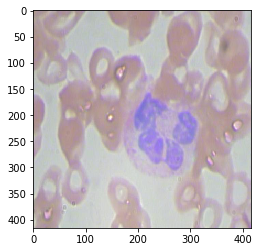

In [17]:
plt.imshow(x_batch[0])

In [18]:
def decode_bboxes_y_true(image_np, y_true_np):
    """
    Returns:
        [(x1, y1, x2, y2), ...] - where x1, y1, x2, y2 are coordinates of 
                                  top-left and bottom-right corners of bounding box
                                  in pixels in image, this can be passed to PIL.Draw
    """

    assert isinstance(image_np, np.ndarray)
    assert image_np.shape == (416, 416, 3)
    assert isinstance(y_true_np, np.ndarray)
    assert y_true_np.shape == (13, 13, 5, 6)

    img_h, img_w, _ = image_np.shape

    grid_w, grid_h, nb_anchors, _ = y_true_np.shape

    cell_w = img_w / grid_w  # 32
    cell_h = img_h / grid_h  # 32

    boundig_boxes = []


    for gx in range(grid_w):
        for gy in range(grid_h):
            for ai in range(nb_anchors):
                anchor = y_true_np[gx][gy][ai]

                if anchor.max() != 0:
                    bbox_center_x = cell_w * anchor[0]
                    bbox_center_y = cell_h * anchor[1]
                    bbox_width = cell_w * anchor[2]
                    bbox_height = cell_h * anchor[3]

                    x1 = bbox_center_x-bbox_width/2
                    y1 = bbox_center_y-bbox_height/2
                    x2 = bbox_center_x+bbox_width/2
                    y2 = bbox_center_y+bbox_height/2

                    boundig_boxes.append((x1, y1, x2, y2))
                    
    return boundig_boxes

In [19]:
def plot_bboxes(image_np, boundig_boxes, color=(255,0,0), width=1):
    pil_img = PIL.Image.fromarray((image_np*255).astype(np.uint8))
    draw = PIL.ImageDraw.Draw(pil_img)
    
    for bbox in boundig_boxes:
        draw.rectangle(bbox, outline=color, width=width)
    
    return pil_img

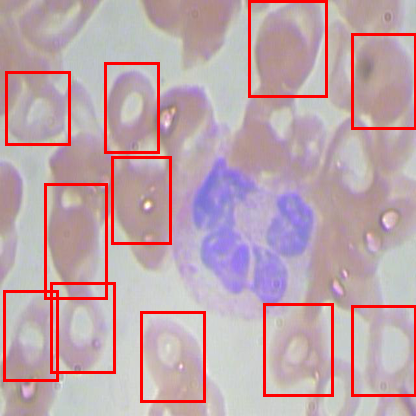

In [20]:
boundig_boxes = decode_bboxes_y_true(x_batch[0], y_batch[0])
pil_img = plot_bboxes(x_batch[0], boundig_boxes, width=3)
display(pil_img)

# Test Model

In [21]:
from tensorflow.keras.layers import Input, Lambda, Reshape, concatenate
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model

In [22]:
class SpaceToDepth(tf.keras.layers.Layer):
    def __init__(self, block_size, **kwargs):
        super(SpaceToDepth, self).__init__(**kwargs)
        self.block_size = block_size
    
    def call(self, x):
        return tf.space_to_depth(x, self.block_size)

In [23]:
def conv_block(X, filters, kernel_size, suffix, max_pool=False):
    X = Conv2D(filters, kernel_size, strides=(1,1), padding='same',
               use_bias=False, name='conv'+suffix)(X)
    X = BatchNormalization(name='norm'+suffix)(X)
    X = LeakyReLU(alpha=0.1)(X)
    if max_pool:
        X = MaxPooling2D(pool_size=(2, 2))(X)
    return X

In [24]:
def create_yolov2(input_size, grid_size, number_anchors, number_classes):

    assert isinstance(input_size, (tuple, list)) and len(input_size) == 2
    assert isinstance(input_size[0], int) and input_size[0] > 0
    assert isinstance(input_size[1], int) and input_size[1] > 0
    assert isinstance(grid_size, (tuple, list)) and len(grid_size) == 2
    assert isinstance(grid_size[0], int) and grid_size[0] > 0
    assert isinstance(grid_size[1], int) and grid_size[1] > 0

    input_height, input_width = input_size
    grid_height, grid_width = grid_size

    IN = Input(shape=(input_height, input_width, 3))

    X = conv_block(IN, filters=32, kernel_size=(3,3), suffix='_1', max_pool=True)
    X = conv_block(X, filters=64, kernel_size=(3,3), suffix='_2', max_pool=True)
    X = conv_block(X, filters=128, kernel_size=(3,3), suffix='_3')
    X = conv_block(X, filters=64, kernel_size=(1,1), suffix='_4')
    X = conv_block(X, filters=128, kernel_size=(3,3), suffix='_5', max_pool=True)
    X = conv_block(X, filters=256, kernel_size=(3,3), suffix='_6')
    X = conv_block(X, filters=128, kernel_size=(1,1), suffix='_7')
    X = conv_block(X, filters=256, kernel_size=(3,3), suffix='_8', max_pool=True)
    X = conv_block(X, filters=512, kernel_size=(3,3), suffix='_9')
    X = conv_block(X, filters=256, kernel_size=(1,1), suffix='_10')
    X = conv_block(X, filters=512, kernel_size=(3,3), suffix='_11')
    X = conv_block(X, filters=256, kernel_size=(1,1), suffix='_12')
    X = conv_block(X, filters=512, kernel_size=(3,3), suffix='_13')

    SK = X  # skip connection

    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_14')
    X = conv_block(X, filters=512, kernel_size=(1,1), suffix='_15')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_16')
    X = conv_block(X, filters=512, kernel_size=(1,1), suffix='_17')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_18')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_19')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_20')

    SK = conv_block(SK, filters=64, kernel_size=(1,1), suffix='_21')
    SK = SpaceToDepth(block_size=2)(SK)
    X = concatenate([SK, X])

    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_22')

    X = Conv2D(filters=number_anchors * (4+1+number_classes),
               kernel_size=(1,1), strides=(1,1), padding='same', name='conv_23')(X)
    
    OUT = Reshape((grid_height, grid_width, number_anchors, 4+1+number_classes))(X)

    model = Model(IN, OUT)
    return model

In [25]:
model = create_yolov2(input_size = (416, 416),  # (height, width)
                      grid_size = (13, 13),     # (height, width)
                      number_anchors = len(anchors),
                      number_classes = len(classes))

Instructions for updating:
Colocations handled automatically by placer.


In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalizationV1)   (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

# Load YOLOv2 Weights

In [27]:
def load_yolov2_weights(model, filepath, last_layer='leave'):
    pointer = 4
    weights = np.fromfile(filepath, dtype='float32')

    for i in range(1, 23):

        #
        #   Norm layers 1..22
        #
        norm_layer = model.get_layer('norm_' + str(i))

        size = np.prod(norm_layer.get_weights()[0].shape)

        beta = weights[pointer:pointer+size]; pointer += size;
        gamma = weights[pointer:pointer+size]; pointer += size;
        mean = weights[pointer:pointer+size]; pointer += size;
        var = weights[pointer:pointer+size]; pointer += size;

        norm_layer.set_weights([gamma, beta, mean, var])

        #
        #   Conv layers 1..22
        #
        conv_layer = model.get_layer('conv_' + str(i))

        size = np.prod(conv_layer.get_weights()[0].shape)
        kernel = weights[pointer:pointer+size]; pointer += size;
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

    #
    #   Conv layer 23
    #
    if last_layer == 'leave':
        pass
    
    elif last_layer == 'load':
        conv_layer = model.get_layer('conv_23')

        size = np.prod(conv_layer.get_weights()[1].shape)
        bias   = weights[pointer:pointer+size]; pointer += size;

        size = np.prod(conv_layer.get_weights()[0].shape)
        kernel = weights[pointer:pointer+size]; pointer += size;
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])

        conv_layer.set_weights([kernel, bias])
        
    elif last_layer == 'rand':
        conv_layer = model.get_layer('conv_23') # the last convolutional layer
        weights = conv_layer.get_weights()
        
        output_shape = model.layers[-1].output_shape
        _, grid_w, grid_h, _, _ = output_shape
        
        new_kernel = np.random.normal(size=weights[0].shape) / (grid_w*grid_h)
        new_bias   = np.random.normal(size=weights[1].shape) / (grid_w*grid_h)

        conv_layer.set_weights([new_kernel, new_bias])
    
    else:
        raise ValueError("Parameter last_layer must be 'leave', 'load' or 'rand'.")

In [28]:
np.random.seed(0)

In [29]:
load_yolov2_weights(model, 'yolov2.weights', last_layer='rand')

In [33]:
netout = model.predict(x_batch)

In [34]:
np.round(netout[0][1][8], 2)

array([[ 0.05, -0.05, -0.09,  0.26,  0.03,  0.2 ],
       [-0.21, -0.11,  0.13,  0.04,  0.08, -0.  ],
       [-0.13, -0.03, -0.11, -0.23,  0.08, -0.05],
       [ 0.08,  0.05,  0.05, -0.03, -0.11, -0.21],
       [-0.05, -0.04, -0.03, -0.1 ,  0.15, -0.08]], dtype=float32)

In [35]:
# np.save('netout.npz', netout)

In [36]:
netout_ref = np.load('netout.npz.npy')

In [37]:
np.all(netout == netout_ref)

True